In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
import nltk
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
true = pd.read_csv("fake-and-real-news-dataset/True.csv")
false = pd.read_csv("fake-and-real-news-dataset/Fake.csv")
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
true['label'] = 'true'
false['label'] = 'false'

In [4]:
data = pd.concat([true, false])

In [5]:
data_copy = data.copy()
data_copy = data_copy.drop(labels=['subject', 'date'], axis='columns')

In [6]:
data_copy = shuffle(data_copy)

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
label_to_index = {'false':0, 'true':1}
y = data_copy.label.apply(lambda x: label_to_index[x])
y = np.asarray(y).astype('float32')
y = tensorflow.keras.utils.to_categorical(y)

In [9]:
data_title1 = data_copy.drop(labels=['text'], axis='columns')
data_text1 = data_copy.drop(labels=['title'], axis='columns')

In [10]:
##複製WORD2VEC

In [11]:
data_text = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data_text1["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    data_text.append(tmp)

del data_text1

In [12]:
##WORD2VEC

In [13]:
import gensim

In [14]:
EMBEDDING_DIM = 100

In [16]:
w2v_model = gensim.models.Word2Vec(sentences=data_text, size=EMBEDDING_DIM, window=5, min_count=1)

In [17]:
len(w2v_model.wv.vocab)

121858

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_text)

data_text = tokenizer.texts_to_sequences(data_text)

In [19]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break     

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
also -> 8
new -> 9
reuters -> 10


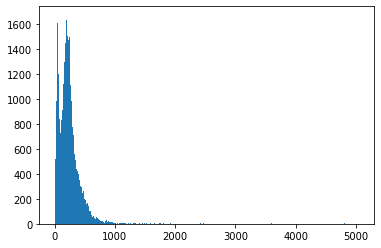

In [20]:
plt.hist([len(x) for x in data_text], bins=500)
plt.show()

In [21]:
nos = np.array([len(x) for x in data_text])
len(nos[nos  < 700])

44020

In [22]:
maxlen = 700 
data_text = pad_sequences(data_text, maxlen=maxlen)

In [23]:
len(data_text[0])

700

In [24]:
vocab_size = len(tokenizer.word_index) + 1

In [25]:
len(tokenizer.word_index)

121858

In [26]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [27]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [28]:
VALIDATION_RATIO = 0.2
RANDOM_STATE = 9527


text_x_train, text_x_val, y_train, y_val = train_test_split(data_text, y, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

In [29]:
RNN_text = Sequential()
RNN_text.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
RNN_text.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
RNN_text.add(Dense(32, activation='relu'))
RNN_text.add(Dense(2, activation='relu'))
RNN_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
RNN_text.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          12185900  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 12,230,286
Trainable params: 44,386
Non-trainable params: 12,185,900
_________________________________________________________________


In [30]:
RNN_text.fit(text_x_train, y_train, batch_size=30, epochs=3, validation_data=(text_x_val, y_val))

Train on 35918 samples, validate on 8980 samples
Epoch 1/3
35918/35918 [==============================] - 3482s 97ms/sample - loss: 0.3926 - accuracy: 0.8897 - val_loss: 0.2295 - val_accuracy: 0.9408
Epoch 2/3
35918/35918 [==============================] - 2693s 75ms/sample - loss: 0.2089 - accuracy: 0.9475 - val_loss: 0.1629 - val_accuracy: 0.9709
Epoch 3/3
35918/35918 [==============================] - 2689s 75ms/sample - loss: 0.1688 - accuracy: 0.9656 - val_loss: 0.1315 - val_accuracy: 0.9764


In [31]:
RNN_text.save('truefakenews_word2vec_RNN.h5')